In [2]:
import pandas as pd
import os
import json
import yfinance as yf # THIS API IS SO COOL, HAS EVERYTHING I NEED
from lets_plot import *
LetsPlot.setup_html()
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #sentiment analysis
from bs4 import BeautifulSoup # scraping tool for getting news articles
import time
import requests
from datetime import datetime, time
import pytz
import sqlite3

<Axes: title={'center': 'Oil Future Prices Over Time'}, xlabel='Years', ylabel='USD'>

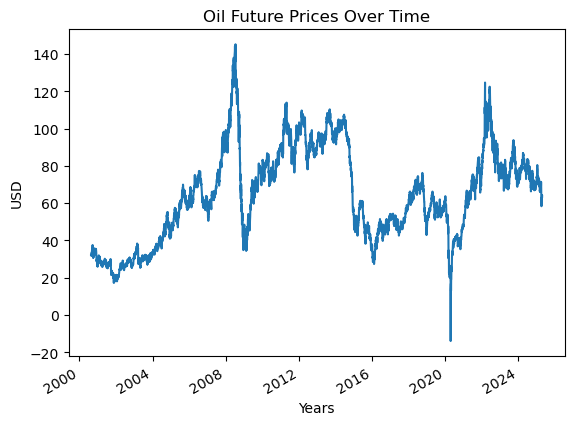

In [5]:
dat = yf.Ticker("CL=F") # oil futures are an accurate way to determine the effect of sentiment

oil_df = dat.history(period="max")

oil_df

oil_df['Open'].plot(title='Oil Future Prices Over Time', xlabel='Years', ylabel = "USD")

In [4]:
def get_news(base_url): 
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text) 

    headlines = []
    for article in soup.find_all(class_='article_name'):
                headline = article.get_text(strip=True)
                headlines.append(headline)

    dates = []
    for date in soup.find_all(class_='categoryArticle__meta'):
                date_author = date.get_text(strip=True)
                dates.append(date_author)

    raw_dict = dict(zip(dates, headlines))

    grouped_dict = {}

    for full_date_str, headline in raw_dict.items():

        # needed to clean that messy metadata into a datetime format
        date_str = full_date_str.split(' at')[0]
        date_obj = datetime.strptime(date_str, '%b %d, %Y').date()
        datetime_midnight = datetime.combine(date_obj, time(0, 0))
        eastern = pytz.timezone("America/New_York")
        datetime_with_tz = eastern.localize(datetime_midnight)
        #code extracts the date from a string, converts it to a datetime object at midnight, and then localizes it to the Eastern Time Zone

        # grouping news articles by dates
        if str(datetime_with_tz) in grouped_dict:
            grouped_dict[str(datetime_with_tz)].append(headline)
        else:
            grouped_dict[str(datetime_with_tz)] = [headline]

    return grouped_dict

In [5]:
# sentiment analysis function here - goes through the values of the dictionary and replaces them with an aggregate sentiment

def get_sentiments(grouped_dict):
    analyzer = SentimentIntensityAnalyzer()

    # replace every news article with it's sentiment score 
    for key in grouped_dict:
        for i in range(len(grouped_dict[key])):
            grouped_dict[key][i] = analyzer.polarity_scores(grouped_dict[key][i])['compound']

    # average out the sentiments and result one value for each date key
    for key in grouped_dict:
        grouped_dict[key] = sum(grouped_dict[key]) / len(grouped_dict[key])

    return grouped_dict


In [12]:
# generating a dataframe that utilizes our two functions to show all functions with each date

base_url = "https://oilprice.com/Latest-Energy-News/World-News/Page-{}.html"

all_news = {}
for i in range(1, 1147): #takes a long time to load :)
    all_news.update(get_sentiments(get_news(base_url.format(i))))

sentiment_df = pd.DataFrame.from_dict(all_news, orient='index', columns=['Aggregate Sentiment'])

sentiment_df

,Aggregate Sentiment
2025-04-21 00:00:00-04:00,0.135820
2025-04-18 00:00:00-04:00,0.147700
2025-04-17 00:00:00-04:00,0.066200
2025-04-16 00:00:00-04:00,0.221867
2025-04-15 00:00:00-04:00,-0.030536
...,...
2011-06-21 00:00:00-04:00,-0.014900
2011-06-20 00:00:00-04:00,-0.057100
2011-06-19 00:00:00-04:00,0.051350
2011-06-18 00:00:00-04:00,-0.447700


In [16]:
# pandas is lovely, it alligns everything by date, makes it easy to combine the databases - saving to a csv because my sql isn't working???

oil_df.index = pd.to_datetime(oil_df.index, utc=True)
sentiment_df.index = pd.to_datetime(sentiment_df.index, utc=True)

oil_df['Sentiment'] = sentiment_df['Aggregate Sentiment']

oil_df

,Open,Volume,Sentiment
Date,,,
2000-08-23 04:00:00+00:00,31.950001,79385,NaN
2000-08-24 04:00:00+00:00,31.900000,72978,NaN
2000-08-25 04:00:00+00:00,31.700001,44601,NaN
2000-08-28 04:00:00+00:00,32.040001,46770,NaN
2000-08-29 04:00:00+00:00,32.820000,49131,NaN
...,...,...,...
2025-04-14 04:00:00+00:00,61.700001,238068,0.212314
2025-04-15 04:00:00+00:00,61.580002,197404,-0.030536
2025-04-16 04:00:00+00:00,61.540001,213194,0.221867


In [17]:
oil_df.to_csv("oil_data.csv")

<Axes: title={'center': 'Oil Price Sentiment Over Time'}, xlabel='Years', ylabel='USD'>

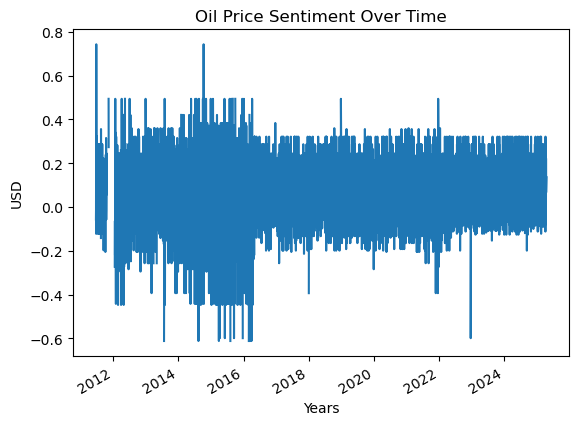

In [21]:
oil_df['Sentiment'].plot(title='Oil Price Sentiment Over Time', xlabel='Years', ylabel = "USD")